In [28]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split , Subset
import torchvision
from pathlib import Path
import time
from collections import defaultdict
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings('ignore')

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
Path('results').mkdir(exist_ok= True)
Path('models').mkdir(exist_ok = True)
Path('visualizations').mkdir(exist_ok = True)

In [31]:
def load_mnist_data():
    '''
    Load MNIST data and split it into train,test and valid
    
    '''

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])

    train_val_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
    
    test_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

    train_size = int(0.8 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size

    train , val = random_split(
        train_val_dataset, [train_size,val_size], generator= torch.Generator().manual_seed(42) 
    )

    print("Dataset Sizes: \n")
    print(f'Training : {len(train)} images')
    print(f'Validation : {len(val)} images')
    print(f'Test : {len(test_dataset)} images')

    return train , val , test_dataset

In [32]:
load_mnist_data()

Dataset Sizes: 

Training : 48000 images
Validation : 12000 images
Test : 10000 images


(<torch.utils.data.dataset.Subset at 0x186e31c4810>,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [33]:
%matplotlib inline

In [34]:
def explore_dataset(dataset, name="Dataset"):

    # Get raw data to analyze (without normalization for visualization)
    raw_transform = transforms.Compose([transforms.ToTensor()])
    raw_dataset = datasets.MNIST(root='./data',train=True,download=False,transform=raw_transform)

    fig , axes = plt.subplots(4, 8 , figsize=(12,8))
    fig.suptitle(f'{name} --- Random Samples',fontsize=12)

    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(raw_dataset))
        image, label = raw_dataset[idx]
        ax.imshow(image.squeeze(),cmap='gray')
        ax.set_title(f'Label : {label}')
        ax.axis(False)
    plt.tight_layout()
    plt.savefig(f'visualizations/{name}_sample.png',dpi=150,bbox_inches='tight')
    plt.show()

    # analyze class distributions
    labels = [raw_dataset[i][1] for i in range(len(raw_dataset))]

    unique, counts = np.unique(labels, return_counts =True)

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.bar(unique, counts, color='steelblue', edgecolor= 'black')
    plt.xlabel('Class of Digits')
    plt.ylabel('number of samples')
    plt.title('Class distribution')
    plt.xticks(unique)

    # Analuze pixel density
    sample_img = torch.stack([raw_dataset[i][0] for i in range(1000)])
    
    plt.subplot(1, 2, 2)
    plt.hist(sample_img.flatten().numpy(), bins=50, color = 'steelblue', edgecolor = 'black' , alpha= 0.7)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f'visualizations/{name}_dist.png',dpi=150,bbox_inches='tight')
    plt.show()

    fig, axes = plt.subplots(3,5,figsize=(15,9))
    fig.suptitle('Example of Each digit class',fontsize=12)

    for digit in range(10):
        idx = labels.index(digit)
        image, label = raw_dataset[idx]

        ax = axes[digit // 5, digit % 5]
        ax.imshow(image.squeeze(),cmap='gray')
        ax.set_title(f'Digit : {digit}')
        ax.axis(False)

    plt.tight_layout()
    plt.savefig(f'visualizations/{name}_digit.png',dpi=150,bbox_inches='tight')
    plt.show()

    print(f"\n Class balance check!!")
    for digit, count in zip(unique,counts):
        print(f' Digit {digit}: {count} samples ({count/ len(labels) * 100:.2f}%)')

In [35]:
class conv_model_simple(nn.Module):
    def __init__(self, num_classes=10):
        super(conv_model_simple, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=32,
                              kernel_size=3,stride=1,
                              padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Normalize activations for stable training

        self.conv2 = nn.Conv2d(in_channels=32,
                              out_channels=64,
                              kernel_size=3,stride=1,
                              padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2) # 14 x 14
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(7 * 7 * 64,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self,x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Dropout after conv layers
        x = self.dropout1(x)
        # Flatten for Fully connected layers
        x = x.view(-1, 7*7*64)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x    

In [36]:
class conv_model_deep(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels= hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels= 2*hidden_units,kernel_size=3,padding=1),
            nn.BatchNorm2d(2*hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels = 2*hidden_units, out_channels=4*hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(4*hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4*hidden_units, out_channels= 4*hidden_units,kernel_size=3,padding=1),
            nn.BatchNorm2d(4*hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7*4 , out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,output_shape)
        )

    def forward(self,x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)

        return x
            

In [37]:
model1 = conv_model_simple(10)
model2 = conv_model_deep(1,32,10)

In [38]:
model1

conv_model_simple(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [39]:
model2

conv_model_deep(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [40]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
class Early_stopping:

    '''
    patience: how many epochs to wait after the last improvement before stopping.
    min_delta: minimum change in validation loss to be considered an improvement.
    counter: counts epochs since last improvement.
    best_loss: tracks the best validation loss seen so far.
    early_stop: flag that becomes True when stopping criteria are met.
    path: file path to save the model checkpoint.
    
    '''

    def __init__(self,patience=10, min_delta=0 , path = 'models/checkpoint.pth'):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):

        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            print(f" Early stopping counter : {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self,model):
        '''save model when val loss decreases'''
        torch.save(model.state_dict(), self.path)

In [42]:
from helper_utils import plot_predictions, MetricsTracker

In [43]:
def train_epoch(model, train_dataloader, criterion, optimizer, device):

    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for X, y in train_dataloader:
        X , y = X.to(device), y.to(device) 

        # Forward propagation
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X.size(0)
        _, predicted = y_pred.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    per_epoch_loss = epoch_loss / total
    epoch_accuracy = (correct / total) * 100.

    return per_epoch_loss, epoch_accuracy
        

In [44]:
def validate(model, val_dataloader, criterion, device):

    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in val_dataloader:
            X , y = X.to(device), y.to(device) 
            y_pred = model(X)
            loss = criterion(y_pred, y)
        
            epoch_loss += loss.item() * X.size(0)
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

    per_epoch_loss = epoch_loss / total
    epoch_accuracy = (correct / total) * 100.

    return per_epoch_loss, epoch_accuracy
        

In [45]:
from tqdm.auto import tqdm

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, device, scheduler = None, model_name = 'model'):

    
    print(f'Training {model_name}')
    print(f'Total Params : {count_params(model):,}')
    print(f'Optimizer: {optimizer.__class__.__name__}')
    print(f'Loss : {criterion.__class__.__name__}')

    model = model.to(device)
    early_stopping = Early_stopping(patience=10, path = f'models/{model_name}_best.pth')
    tracker = MetricsTracker()

    start_time = time.time()

    for epoch in tqdm(range(epochs)):

        train_loss ,train_accuracy = train_epoch(model, train_dataloader, criterion, optimizer, device)

        val_loss , val_accuracy = validate(model, val_dataloader, criterion, device)

        current_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:
            scheduler.step(val_loss)

        tracker.update({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'learning_rate': current_lr
        })

        print(f'Epoch [{epoch + 1}/{epochs}] '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | '
              f'LR: {current_lr:.5f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("trigerring early stopping !!!")
            break

    train_time = time.time() - start_time
    print(f"Total training took {train_time:.3f} seconds on {torch.cuda.get_device_name(0)}")

    model.load_state_dict(torch.load(f'models/{model_name}_best.pth'))

    tracker.plot_history(f'visualizations/{model_name}_hist.png')

    return model, tracker
        
    

In [46]:
def evaluate_model(model, test_loader , device):

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    inference_times = []

    with torch.no_grad():
        for inputs , labels in test_loader:
            inputs = inputs.to(device)
            start = time.time()
            outputs = model(inputs)
            inference_times.append(time.time() - start)

            probs = F.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)
    avg_inference_time = np.mean(inference_times) * 1000 # converted into ms

    print(f'Accuracy now: {accuracy:.2f}%')
    print(f'inference_time is: {avg_inference_time:.4f} seconds')

    print("\n Classification report ---")

    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))
    return all_preds , all_labels , all_probs

In [47]:
def plot_confusion_matrix(labels, preds, save_path = 'visualizations/confusion_matrix.png'):

    cm = confusion_matrix(labels,preds)

    plt.figure(figsize=(12,8))
    sns.heatmap(cm , annot = True , fmt = 'd', cmap = "Blues" , xticklabels = range(10), yticklabels = range(10))
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print("\n Common confusions: ")

    for i in range(10):
        for j in range(10):
            if i != j and cm[i,j] > 20:
                print(f" {i} confused as {j} : {cm[i,j]} times")
    

In [48]:
def visualize_predictions(model, test_dataset , device, sample=10):

    model.eval()

    index = np.random.choice(len(test_dataset), sample, replace= False)

    fig, axes = plt.subplots(2,5,figsize=(12,8))
    fig.suptitle('Model Predictions with Confidence', fontsize=14)

    with torch.no_grad():
        for idx, ax in zip(index, axes.flat):

            image , true_label = test_dataset[idx]

            # Get prediction
            output = model(image.unsqueeze(dim=0).to(device))
            probs = F.softmax(output, dim=1)
            conf , pred = probs.max(1)

            # Denormalize image for visualization
            img = image.squeeze().cpu().numpy() * 0.3081 + 0.1307

            ax.imshow(img, cmap='gray')

            color = 'green' if pred.item() == true_label else 'red'
            ax.set_title(f'True : {true_label} | Pred : {pred.item()} \n Confidence : {conf.item() * 100 : .2f}%', color=color, fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('visualizations/predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [49]:
def analyze_errors(model, test_dataset, device, num_errors=16):


    model.eval()
    errors = []

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            image, true_label = test_dataset[idx]
            output = model(image.unsqueeze(0).to(device))
            _, pred = output.max(1)

            if pred.item() != true_label:
                probs = F.softmax(output, dim=1)
                errors.append((idx, true_label, pred.item(), probs[0]))

            if len(errors) >= num_errors:
                break

    if len(errors) == 0:
        print("No errors found in the first samples!")
        return

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Error Analysis - Understanding Mistakes', fontsize=16)

    for (idx, true_label, pred_label, probs), ax in zip(errors, axes.flat):
        image, _ = test_dataset[idx]
        img = image.squeeze().cpu().numpy() * 0.3081 + 0.1307

        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label} → Predicted: {pred_label}\n'
                     f'Confidence: {probs[pred_label] * 100:.1f}%',
                     color='red', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('visualizations/error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    error_confidences = [probs[pred].item() for _, _, pred, probs in errors]

    plt.figure(figsize=(10, 5))
    plt.hist(error_confidences, bins=20, color='red', alpha=0.7, edgecolor='black')
    plt.xlabel('Model Confidence on Errors')
    plt.ylabel('Frequency')
    plt.title('How Confident is the Model When It\'s Wrong?')
    plt.axvline(np.mean(error_confidences), color='black', linestyle='--',
                label=f'Mean: {np.mean(error_confidences):.2f}')
    plt.legend()
    plt.savefig('visualizations/error_confidence.png', dpi=150, bbox_inches='tight')
    plt.show()

In [50]:
def visualize_filters(model, save_path='visualizations/conv_filters.png'):
    

    # Get first conv layer
    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break

    if first_conv is None:
        print("No convolutional layer found!")
        return

    # Get filters
    filters = first_conv.weight.data.cpu().clone()
    num_filters = min(32, filters.shape[0])  # Show up to 32 filters

    # Normalize filters for visualization
    filters = filters[:num_filters]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle('First Layer Filters - What Patterns Does the CNN Look For?', fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            f = filters[i, 0]
            # Normalize to [0, 1] for display
            f = (f - f.min()) / (f.max() - f.min() + 1e-8)
            ax.imshow(f, cmap='viridis')
            ax.set_title(f'Filter {i}', fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [51]:
def visualize_feature_maps(model, test_dataset, device, sample_idx=0):
    

    model.eval()

    # Get a sample image
    image, label = test_dataset[sample_idx]
    img_display = image.squeeze().cpu().numpy() * 0.3081 + 0.1307

    # Forward pass with hooks to capture intermediate outputs
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())

    # Register hooks for conv layers
    hooks = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Visualize
    num_layers = len(activations)
    fig = plt.figure(figsize=(20, 4 * num_layers))

    # Show original image
    plt.subplot(num_layers + 1, 8, 1)
    plt.imshow(img_display, cmap='gray')
    plt.title(f'Input Image\nLabel: {label}', fontsize=10)
    plt.axis('off')

    # Show feature maps from each layer
    for layer_idx, activation in enumerate(activations):
        activation = activation.squeeze()
        num_channels = min(8, activation.shape[0])

        for ch in range(num_channels):
            plt.subplot(num_layers + 1, 8, (layer_idx + 1) * 8 + ch + 1)
            fmap = activation[ch].numpy()
            plt.imshow(fmap, cmap='viridis')
            if ch == 0:
                plt.title(f'Layer {layer_idx + 1}\nChannel {ch}', fontsize=8)
            else:
                plt.title(f'Ch {ch}', fontsize=8)
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('visualizations/feature_maps.png', dpi=150, bbox_inches='tight')
    plt.show()

In [52]:
def compare_optimizers(model_class, train_dataloader, val_dataloader, device):

    print("\nCOMPARING OPTIMIZERS !!!")
    
    '''
    optimizer_1 = torch.optim.SGD(params = model_blob.parameters(),lr = 0.01)
    optimizer_2 = torch.optim.RMSprop(params = model_blob.parameters(),lr = 0.01)
    optimizer_3 = torch.optim.Adam(params = model_blob.parameters(),lr = 0.01)
    optimizer = {
        'SGD' : optimizer_1,
        'RMSprop' : optimizer_2,
        'Adam' : optimizer_3
    }
    
    '''
    optimizer = {
        #'SGD' : lambda params: torch.optim.SGD(params, lr = 0.001, momentum = 0.937),
        'Adam': lambda params: torch.optim.Adam(params, lr=0.001, weight_decay=1e-5),
        #'AdamW': lambda params: torch.optim.AdamW(params, lr=0.001 , weight_decay = 0.01),
        #'RMSprop': lambda params: torch.optim.RMSprop(params, lr=0.001,weight_decay=1e-4)
    }

    results = {}

    for opt_name, opt_fn in optimizer.items():
        print(f'\nThe optimizer used is {opt_name}')

        model = model_class().to(device)
        optimizer = opt_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer , mode = 'min' , factor = 0.5, patience = 10, verbose = True
        )

        trained_model, tracker = train_model(
            model, train_dataloader , val_dataloader , criterion , optimizer , epochs = 30, device = device ,scheduler=scheduler,
            model_name = f'SimpleCNN_{opt_name}'
        )

        results[opt_name] = {
            'model' : trained_model,
            'tracker' : tracker,
            "final_val_acc" : tracker.history['val_acc'][-1]
        }

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for opt_name, result in results.items():
        plt.plot(result['tracker'].history['val_loss'],
                 label=opt_name, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    for opt_name, result in results.items():
        plt.plot(result['tracker'].history['val_acc'],
                 label=opt_name, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('visualizations/optimizer_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n{'=' * 60}")
    print("OPTIMIZER COMPARISON SUMMARY")
    print(f"{'=' * 60}")
    for opt_name, result in sorted(results.items(),
                                   key=lambda x: x[1]['final_val_acc'],
                                   reverse=True):
        print(f"{opt_name:10s}: {result['final_val_acc']:.2f}% validation accuracy")

    return results
        

In [53]:
def main():

    print("< MNIST CNN PROJECT >")
    print("==" * 20)

    train_dataset , val_dataset , test_dataset = load_mnist_data()
    explore_dataset(train_dataset, "MNIST Training Set")

    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = 2, pin_memory = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers = 2, pin_memory = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = 2, pin_memory = True)

    print(f'Comparing different optimizers .....')
    optimizer_results = compare_optimizers(conv_model_simple, train_loader, val_loader, device)

    best_opt = max(optimizer_results.items(), key = lambda x: x[1]['final_val_acc'])
    print(f"\nBest optimizer: {best_opt[0]}")
    best_model = best_opt[1]['model']

    deep_model = conv_model_deep(1,32,10).to(device)
    optimizer = torch.optim.Adam(deep_model.parameters(), lr = 0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    deep_model , tracker_deep = train_model(
        deep_model, train_loader, val_loader, criterion, optimizer,
        epochs= 30, device=device, scheduler=scheduler,
        model_name='DeeperCNN'
    )

    print("\n Evaluating Best model on test set")
    preds, labels, probs = evaluate_model(best_model, test_loader, device)

    plot_confusion_matrix(labels,preds)
    visualize_predictions(best_model, test_dataset, device, sample=10)
    analyze_errors(best_model, test_dataset, device, num_errors=16)
    print("\n Visualizing learned features...")
    visualize_filters(best_model)
    visualize_feature_maps(best_model, test_dataset, device, sample_idx=0)

    print("PROJECT SUMMARY")
    print(f"{'=' * 60}")
    print(f"Best Model: SimpleCNN with {best_opt[0]} optimizer")
    print(f"Parameters: {count_params(best_model):,}")
    print(f"Final Test Accuracy: {100. * (preds == labels).sum() / len(labels):.2f}%")
    print(f"\nAll visualizations saved to 'visualizations/' directory")
    print(f"All models saved to 'models/' directory")
    

< MNIST CNN PROJECT >
Dataset Sizes: 

Training : 48000 images
Validation : 12000 images
Test : 10000 images


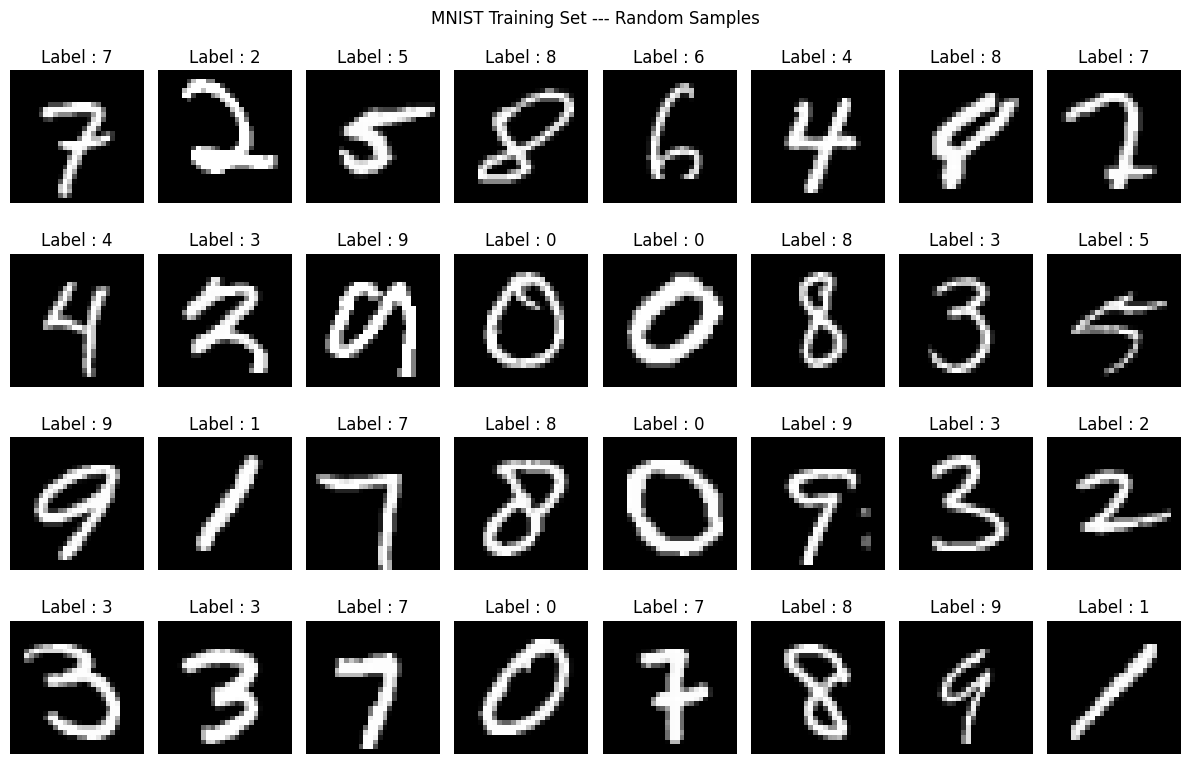

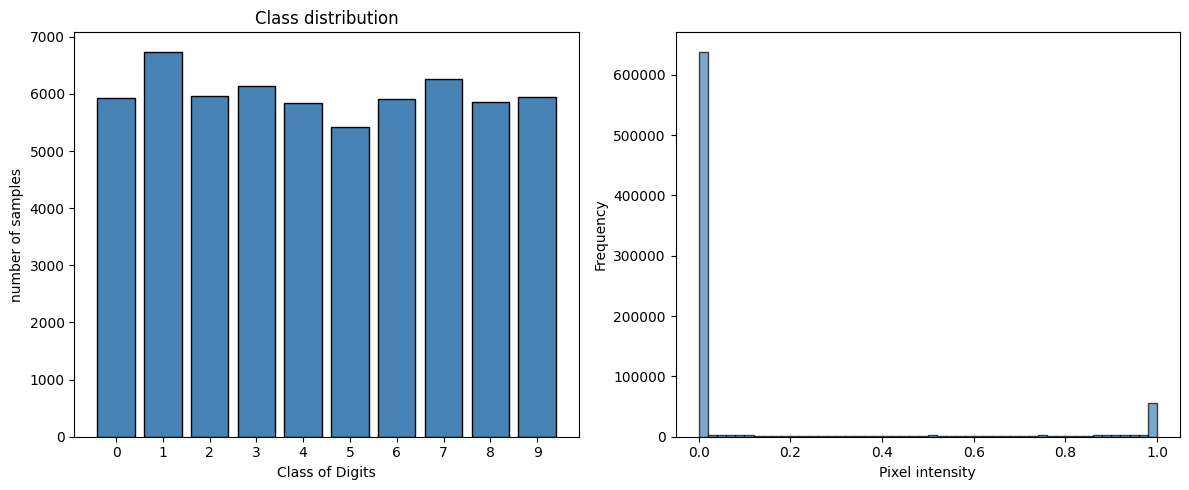

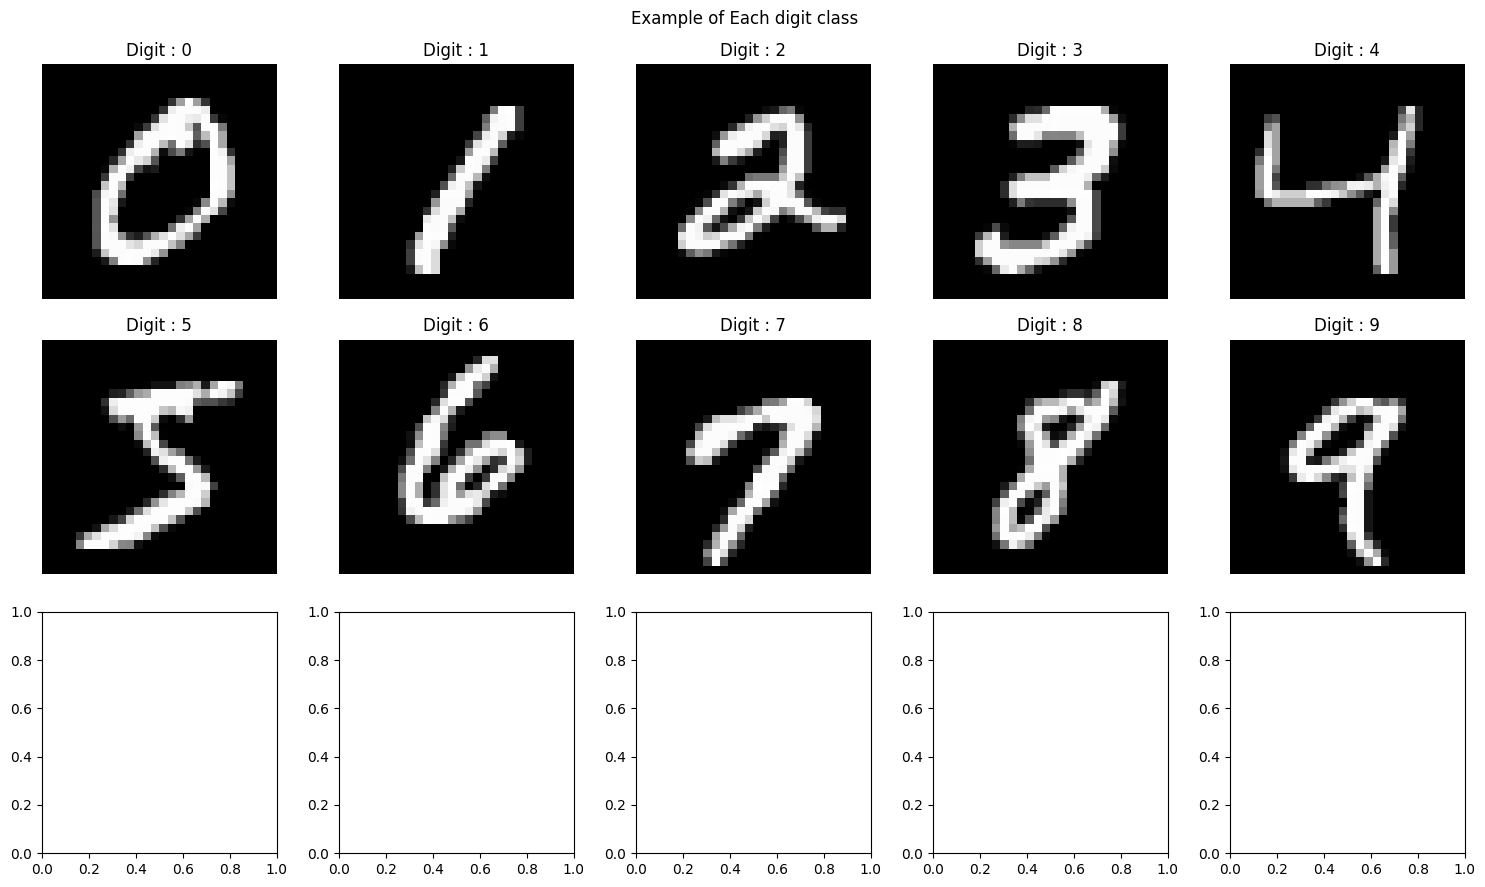


 Class balance check!!
 Digit 0: 5923 samples (9.87%)
 Digit 1: 6742 samples (11.24%)
 Digit 2: 5958 samples (9.93%)
 Digit 3: 6131 samples (10.22%)
 Digit 4: 5842 samples (9.74%)
 Digit 5: 5421 samples (9.04%)
 Digit 6: 5918 samples (9.86%)
 Digit 7: 6265 samples (10.44%)
 Digit 8: 5851 samples (9.75%)
 Digit 9: 5949 samples (9.92%)
Comparing different optimizers .....

COMPARING OPTIMIZERS !!!

The optimizer used is Adam
Training SimpleCNN_Adam
Total Params : 421,834
Optimizer: Adam
Loss : CrossEntropyLoss


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30] Train Loss: 0.2372 | Train Acc: 92.71% | Val Loss: 0.0569 | Val Acc: 98.39% | LR: 0.00100
Epoch [2/30] Train Loss: 0.0992 | Train Acc: 97.08% | Val Loss: 0.0512 | Val Acc: 98.37% | LR: 0.00100
Epoch [3/30] Train Loss: 0.0795 | Train Acc: 97.55% | Val Loss: 0.0435 | Val Acc: 98.72% | LR: 0.00100
Epoch [4/30] Train Loss: 0.0693 | Train Acc: 97.93% | Val Loss: 0.0393 | Val Acc: 98.80% | LR: 0.00100
Epoch [5/30] Train Loss: 0.0589 | Train Acc: 98.19% | Val Loss: 0.0388 | Val Acc: 98.91% | LR: 0.00100
Epoch [6/30] Train Loss: 0.0557 | Train Acc: 98.28% | Val Loss: 0.0338 | Val Acc: 98.96% | LR: 0.00100
Epoch [7/30] Train Loss: 0.0511 | Train Acc: 98.40% | Val Loss: 0.0348 | Val Acc: 99.02% | LR: 0.00100
 Early stopping counter : 1 out of 10
Epoch [8/30] Train Loss: 0.0447 | Train Acc: 98.63% | Val Loss: 0.0331 | Val Acc: 99.02% | LR: 0.00100
Epoch [9/30] Train Loss: 0.0435 | Train Acc: 98.63% | Val Loss: 0.0366 | Val Acc: 98.88% | LR: 0.00100
 Early stopping counter : 1 out of 

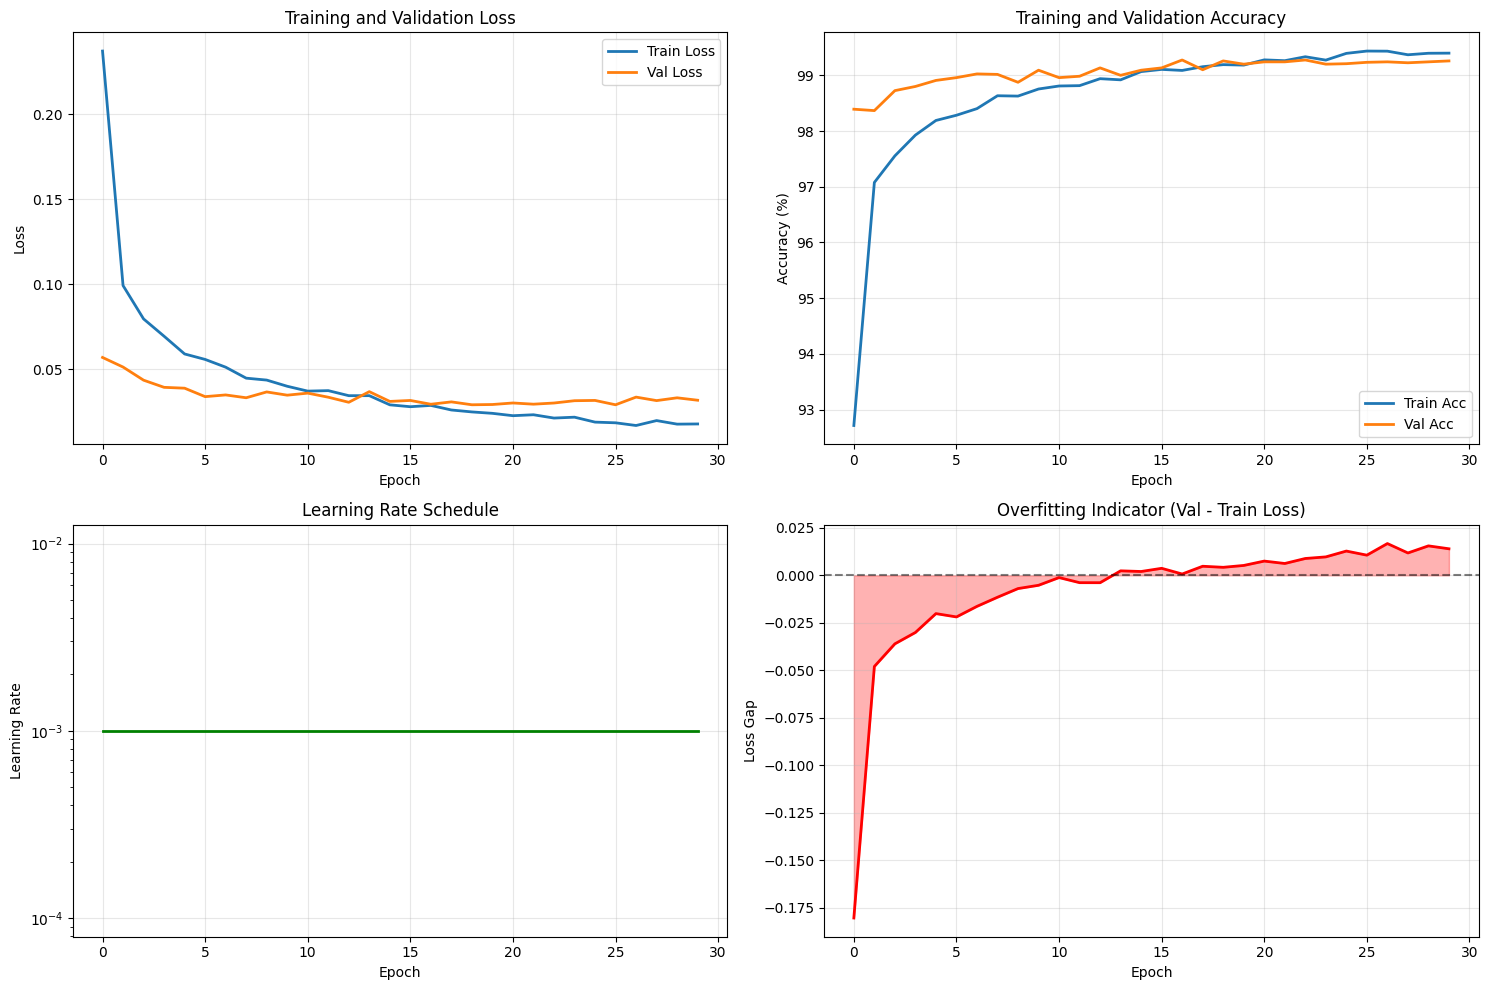

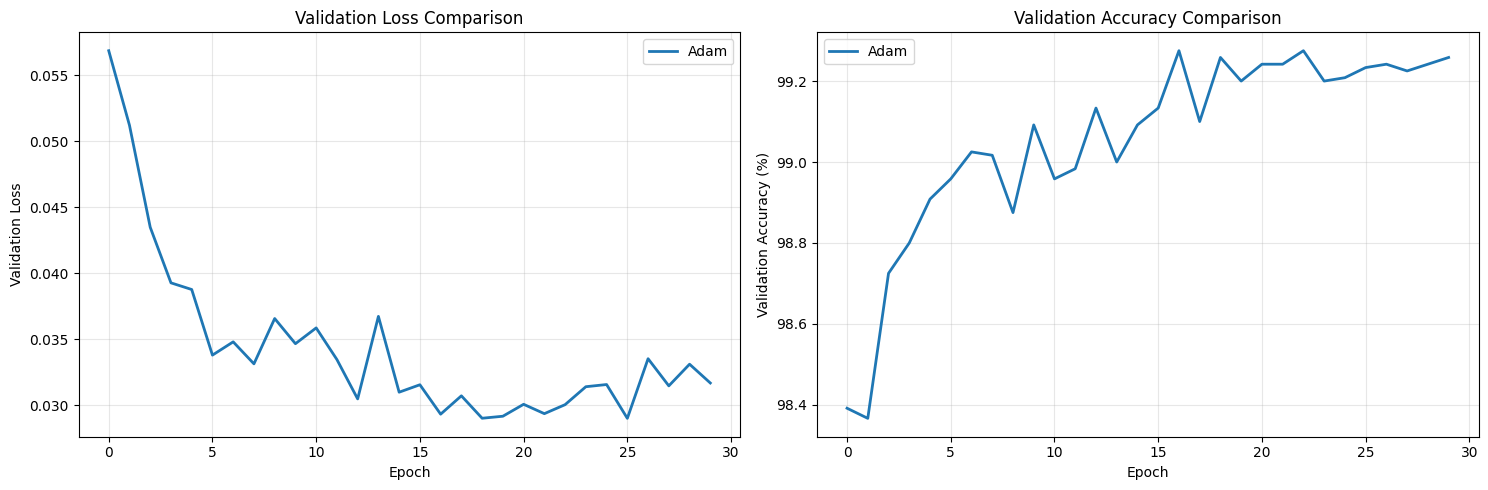


OPTIMIZER COMPARISON SUMMARY
Adam      : 99.26% validation accuracy

Best optimizer: Adam
Training DeeperCNN
Total Params : 1,045,194
Optimizer: Adam
Loss : CrossEntropyLoss


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30] Train Loss: 0.3732 | Train Acc: 88.13% | Val Loss: 0.0791 | Val Acc: 97.42% | LR: 0.00100
Epoch [2/30] Train Loss: 0.1599 | Train Acc: 94.95% | Val Loss: 0.0589 | Val Acc: 98.16% | LR: 0.00100
Epoch [3/30] Train Loss: 0.1319 | Train Acc: 95.88% | Val Loss: 0.0500 | Val Acc: 98.58% | LR: 0.00100
Epoch [4/30] Train Loss: 0.1120 | Train Acc: 96.27% | Val Loss: 0.0448 | Val Acc: 98.68% | LR: 0.00100
Epoch [5/30] Train Loss: 0.1040 | Train Acc: 96.57% | Val Loss: 0.0348 | Val Acc: 99.04% | LR: 0.00100
Epoch [6/30] Train Loss: 0.0969 | Train Acc: 96.73% | Val Loss: 0.0329 | Val Acc: 99.05% | LR: 0.00100
Epoch [7/30] Train Loss: 0.0916 | Train Acc: 96.93% | Val Loss: 0.0377 | Val Acc: 98.82% | LR: 0.00100
 Early stopping counter : 1 out of 10
Epoch [8/30] Train Loss: 0.0844 | Train Acc: 97.14% | Val Loss: 0.0309 | Val Acc: 99.12% | LR: 0.00100
Epoch [9/30] Train Loss: 0.0793 | Train Acc: 97.31% | Val Loss: 0.0343 | Val Acc: 99.06% | LR: 0.00100
 Early stopping counter : 1 out of 

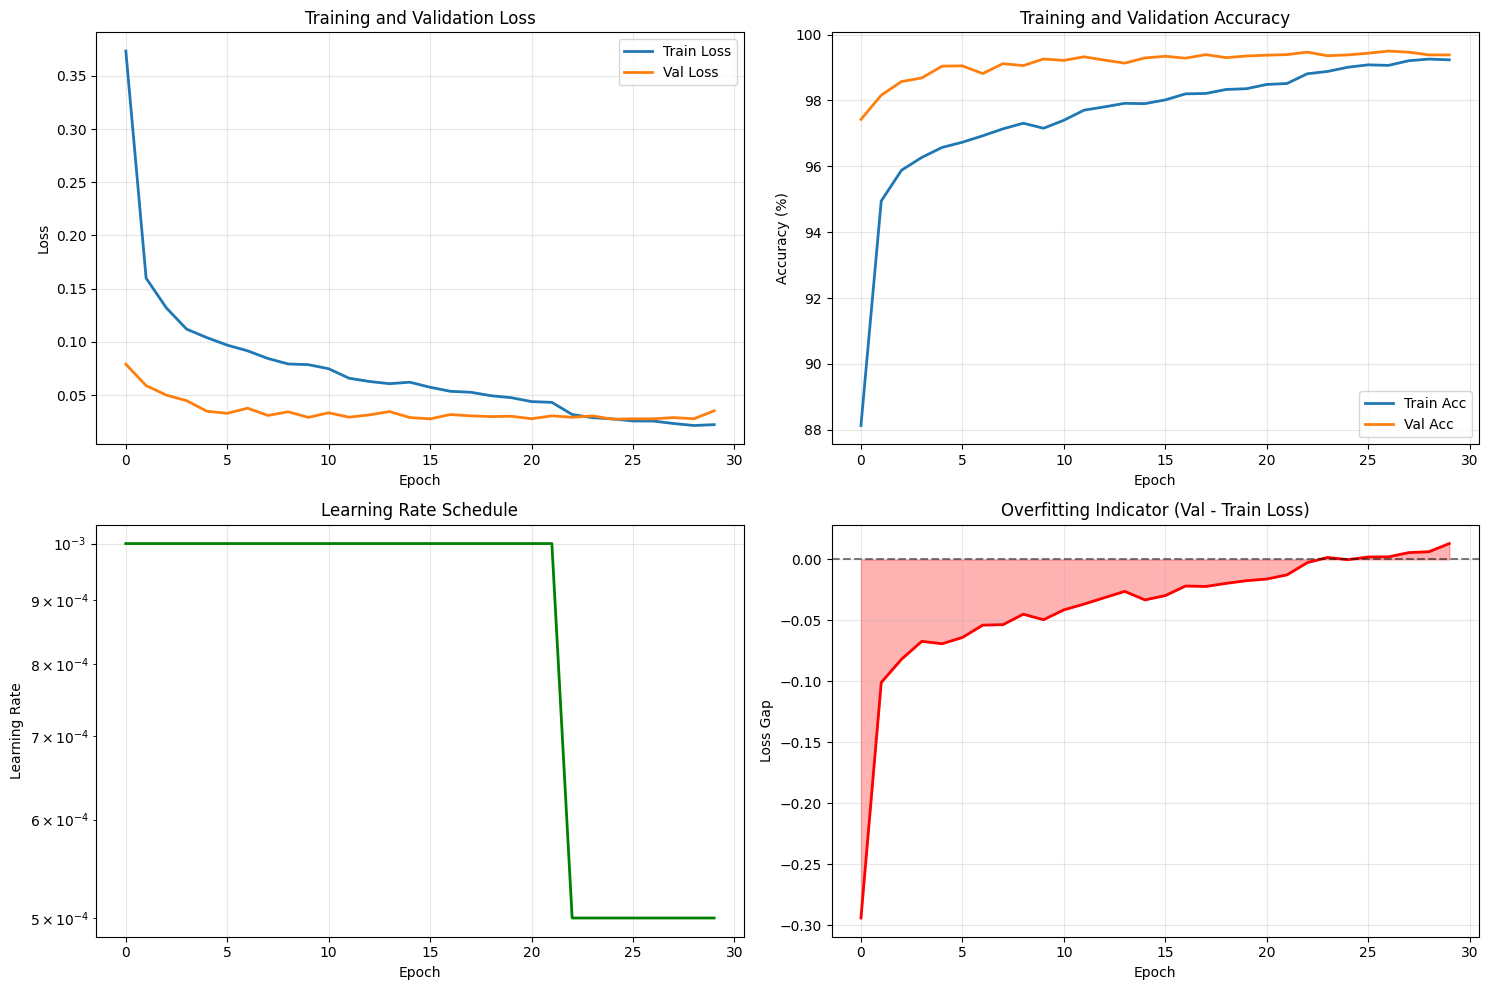


 Evaluating Best model on test set
Accuracy now: 99.32%
inference_time is: 0.4105 seconds

 Classification report ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



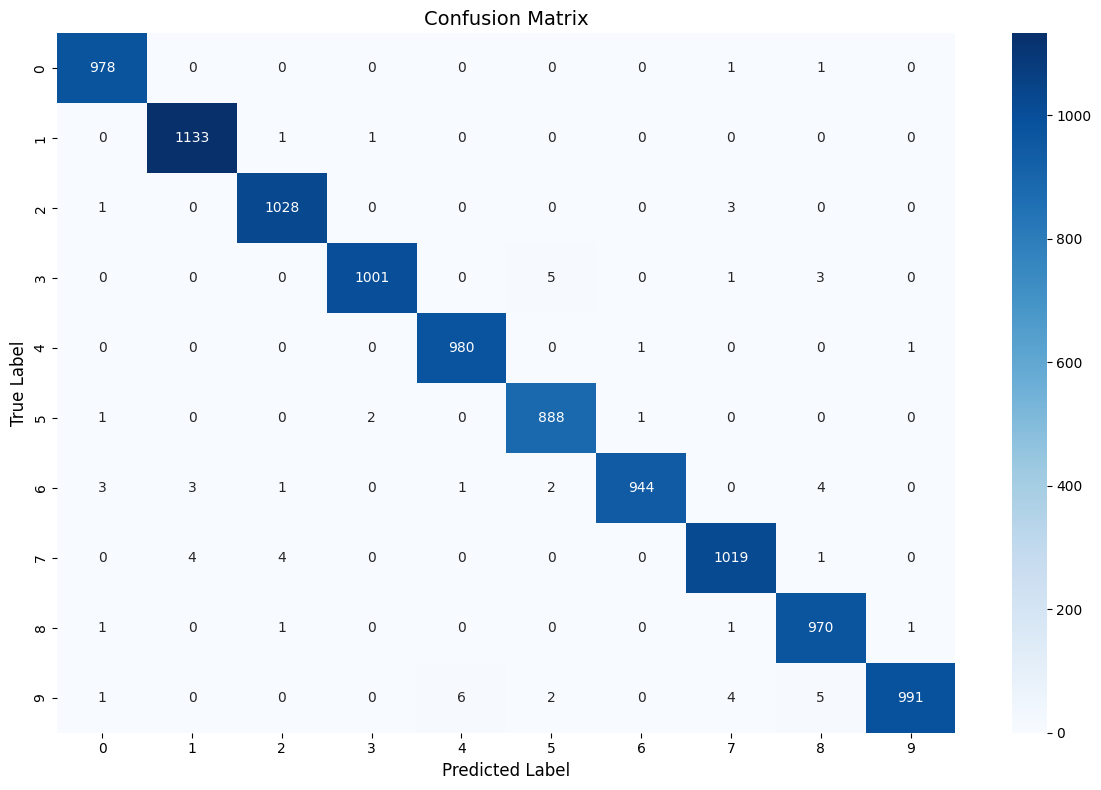


 Common confusions: 


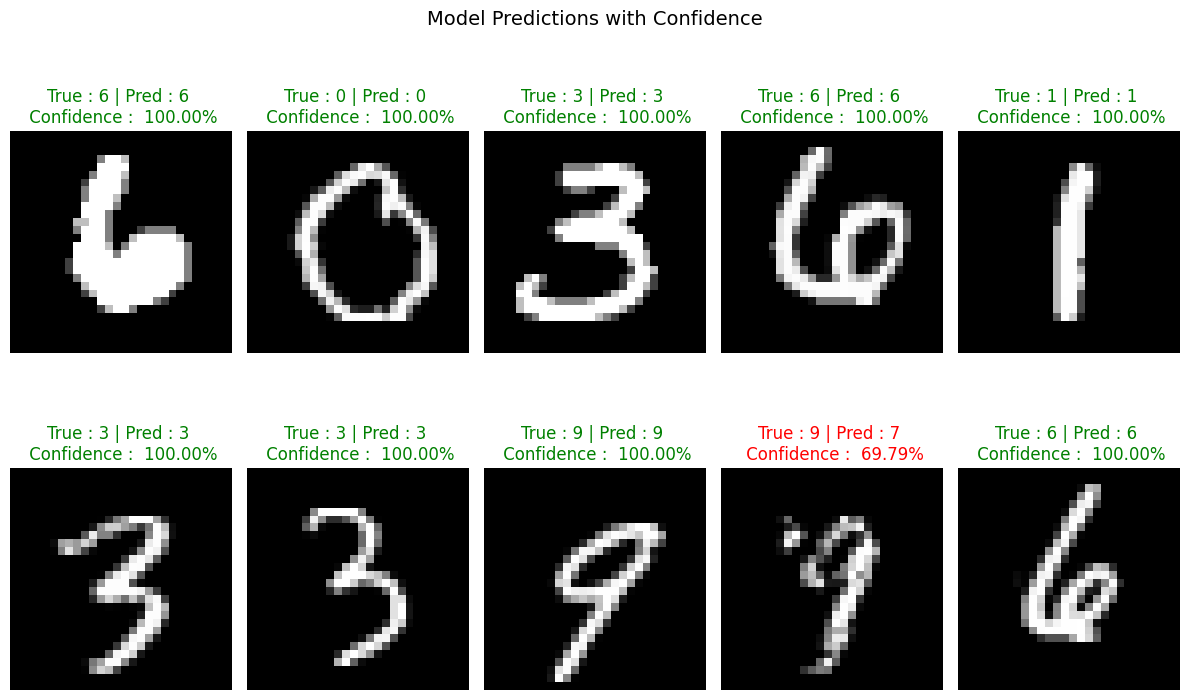

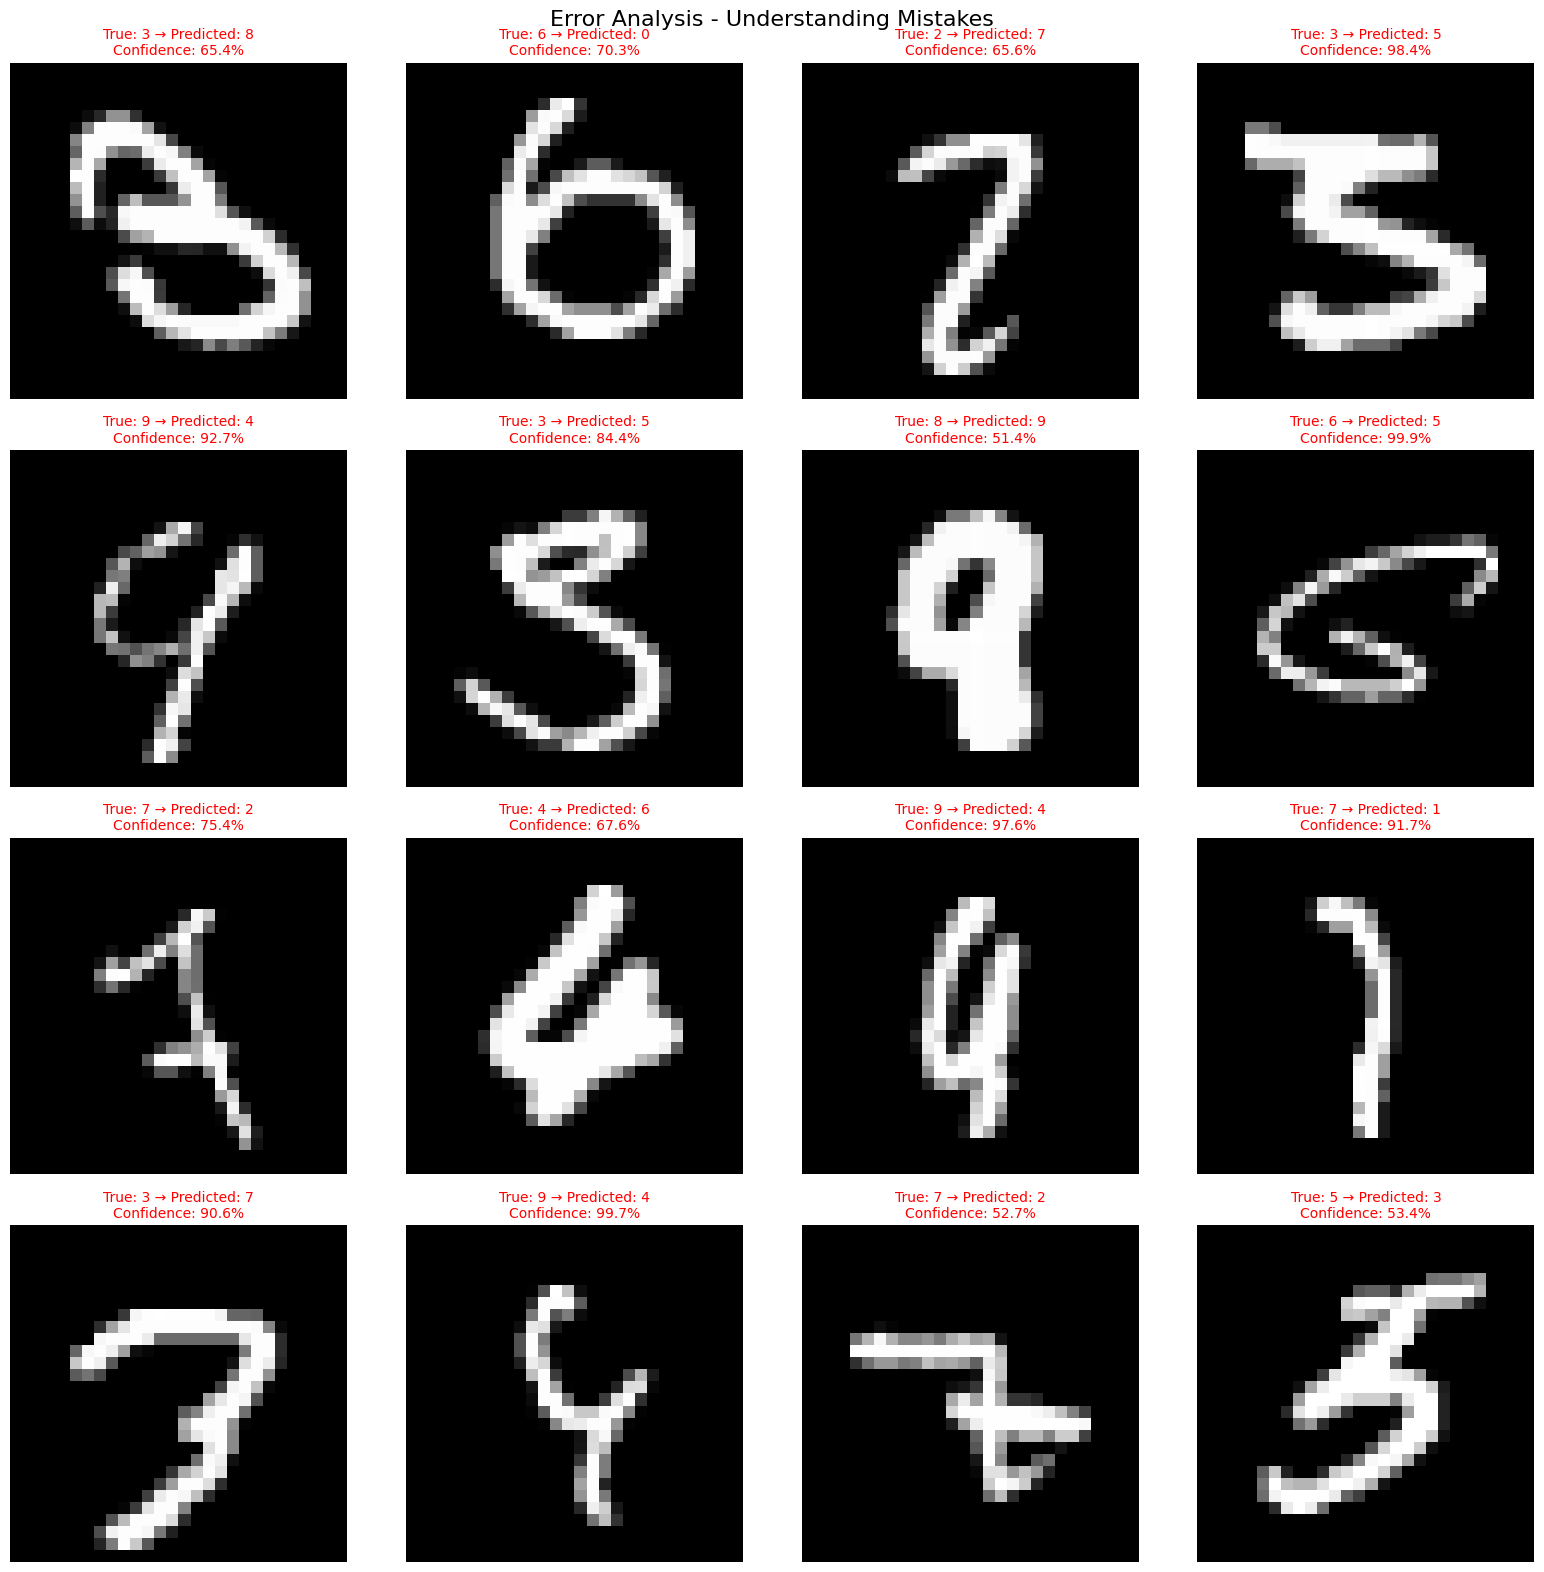

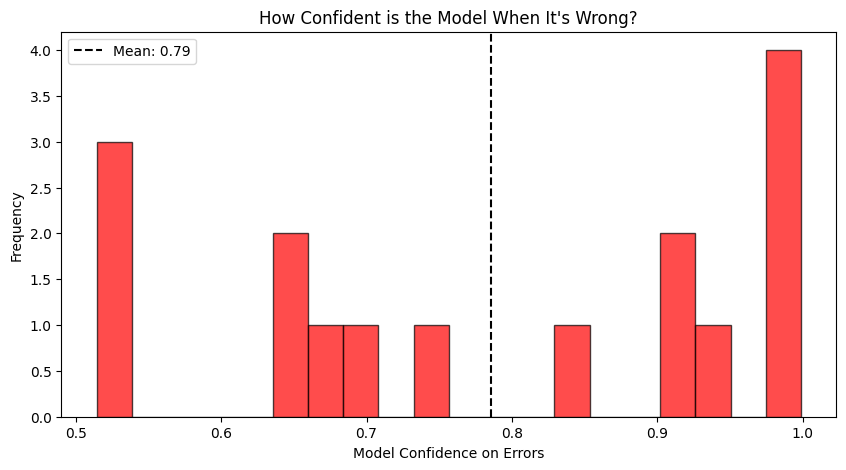


 Visualizing learned features...


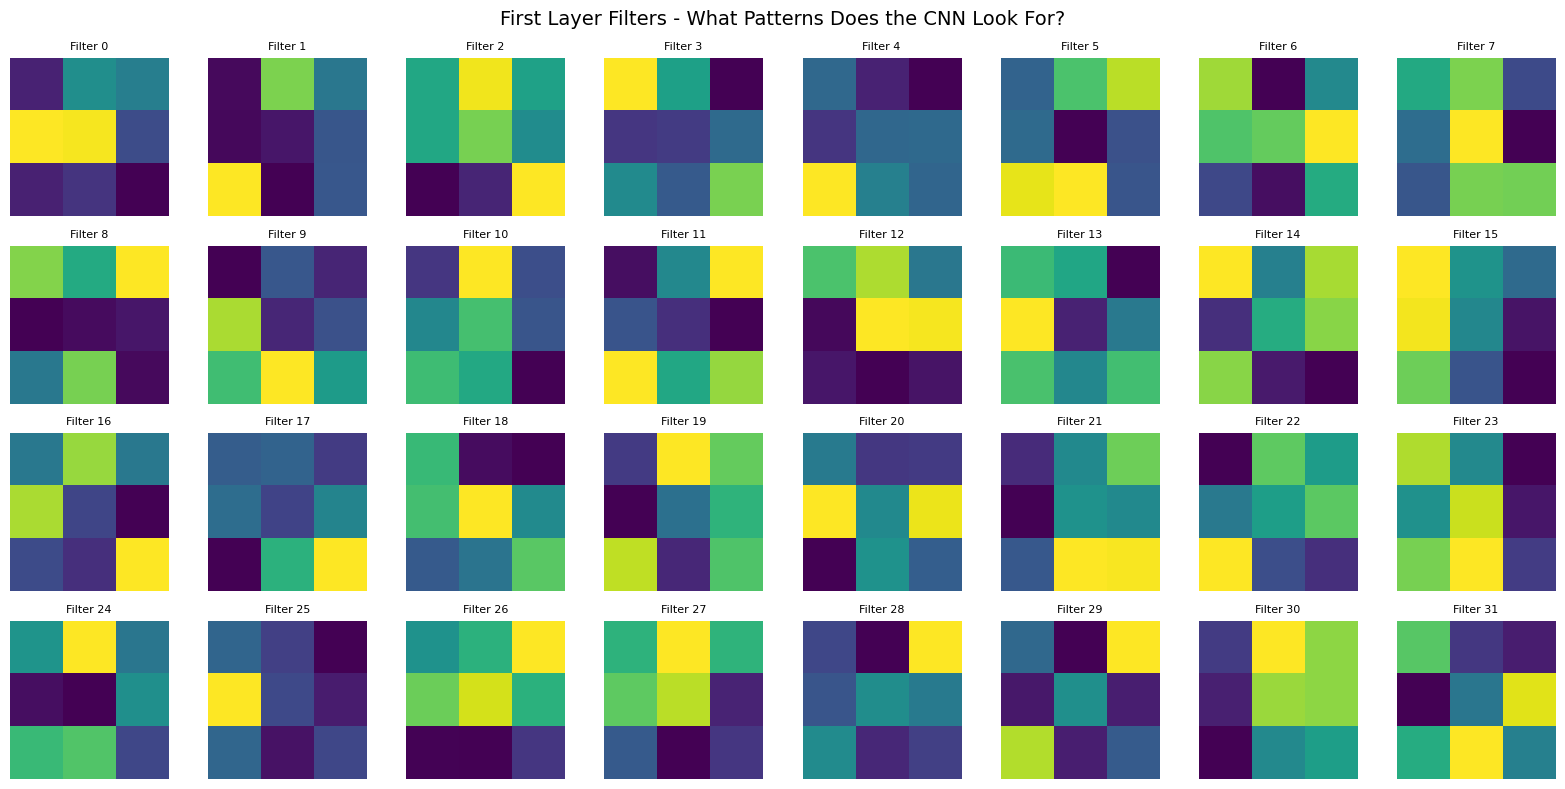

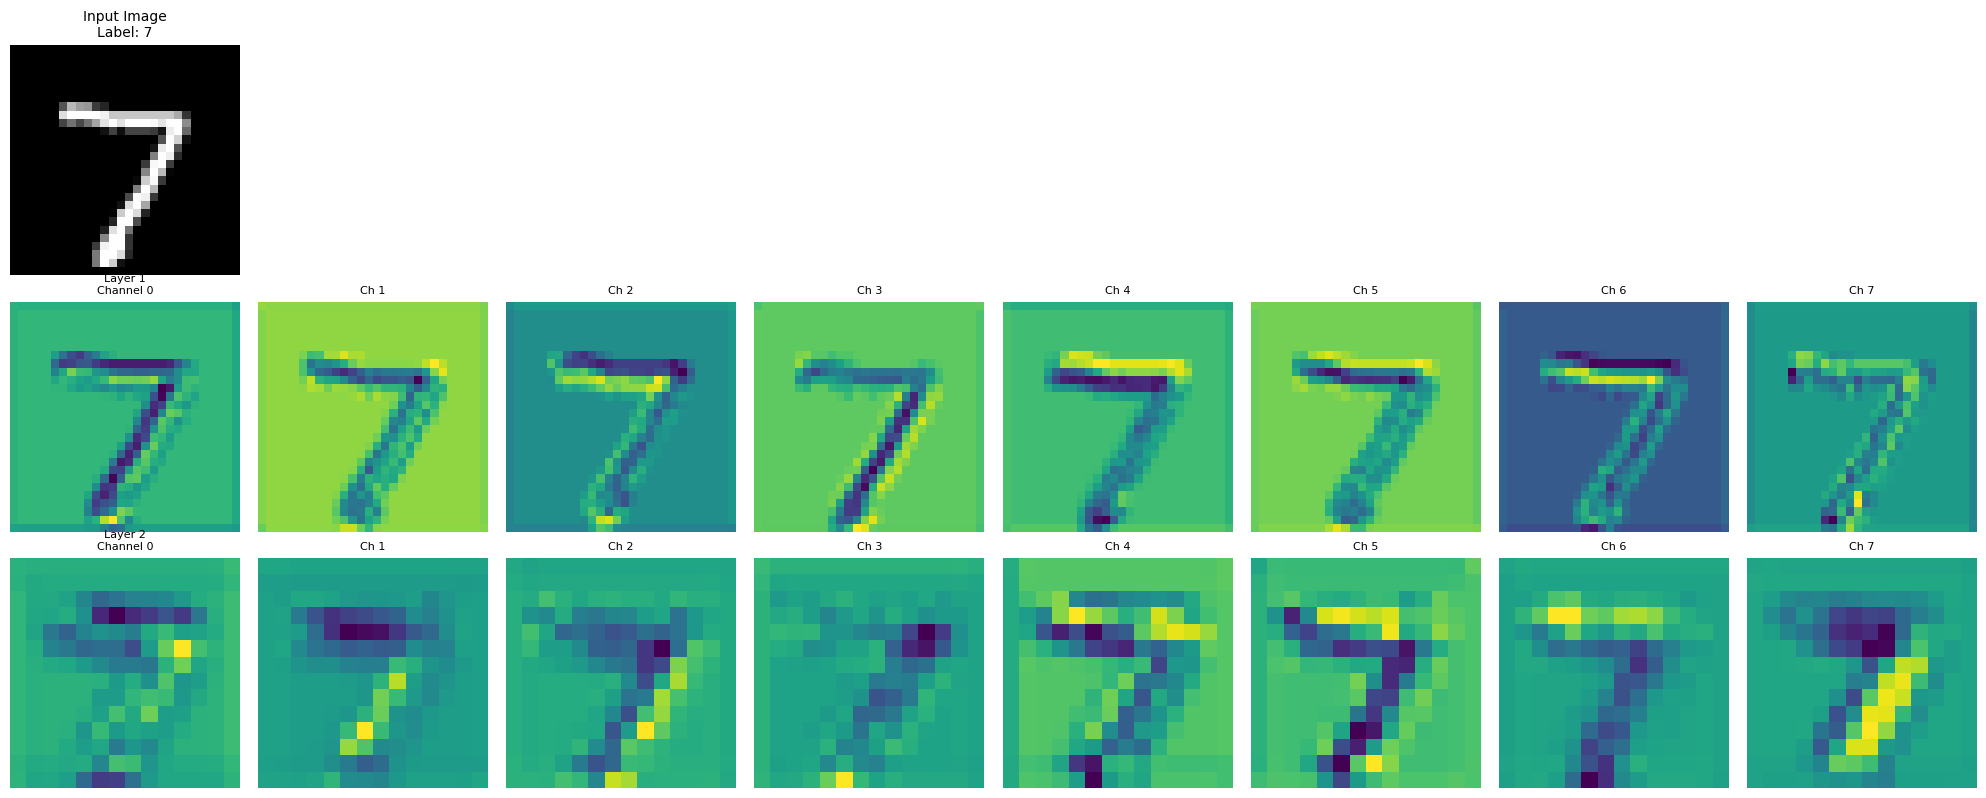

PROJECT SUMMARY
Best Model: SimpleCNN with Adam optimizer
Parameters: 421,834
Final Test Accuracy: 99.32%

All visualizations saved to 'visualizations/' directory
All models saved to 'models/' directory


In [54]:
if __name__ == "__main__":
    main()